In [124]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")
from imageio import imread

In [125]:
vggnet = torchvision.models.vgg19(weights=torchvision.models.VGG19_Weights.DEFAULT)

In [126]:
# Freeze all the layers
for p in vggnet.parameters():
    p.requires_grad = False

In [127]:
vggnet.eval()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
vggnet.to(device=device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [128]:
for p in vggnet.named_parameters():
    print(p[0])

features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.16.weight
features.16.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.23.weight
features.23.bias
features.25.weight
features.25.bias
features.28.weight
features.28.bias
features.30.weight
features.30.bias
features.32.weight
features.32.bias
features.34.weight
features.34.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


In [129]:
img_content = imread("museum.jpg")
img_content.shape

/tmp/ipykernel_1570496/848458599.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_content = imread("museum.jpg")


(1072, 1920, 3)

In [130]:
img_style = imread("scream.jpg")
img_style.shape

/tmp/ipykernel_1570496/3052219725.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_style = imread("scream.jpg")


(273, 220, 3)

In [131]:
img_target = np.random.randint(low=0, high=255, size=img_content.shape, dtype=np.uint8)
img_target.shape

(1072, 1920, 3)

In [132]:
Ts = T.Compose([T.ToTensor(),
                T.Resize(256),
                T.Normalize(mean=[.485, .456, .406], std=[.229, .224, .225])
                ])

In [133]:
img_content = Ts(img_content).unsqueeze(0).to(device=device)
img_style = Ts(img_style).unsqueeze(0).to(device=device)
img_target = Ts(img_target).unsqueeze(0).to(device=device)

img_content.shape, img_style.shape, img_target.shape

(torch.Size([1, 3, 256, 458]),
 torch.Size([1, 3, 317, 256]),
 torch.Size([1, 3, 256, 458]))

In [134]:
img_style.requires_grad = True
img_content.requires_grad = True

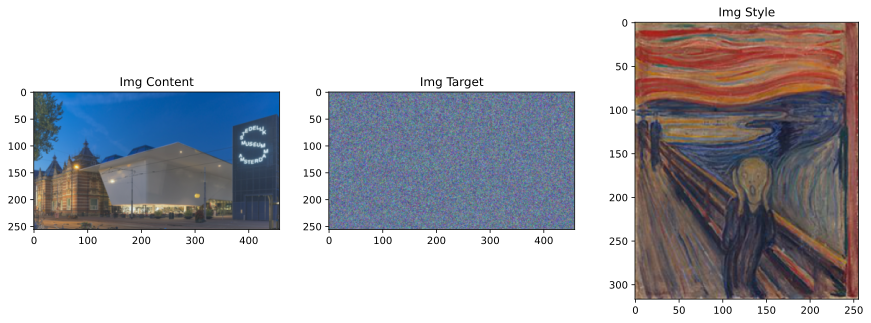

In [135]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

pic = img_content.cpu().squeeze().permute(1, 2, 0).detach().numpy()
pic = (pic - np.min(pic))/(np.max(pic) - np.min(pic))
ax[0].imshow(pic)
ax[0].set_title("Img Content")

pic = img_target.cpu().squeeze().permute(1, 2, 0).detach().numpy()
pic = (pic - np.min(pic))/(np.max(pic) - np.min(pic))
ax[1].imshow(pic)
ax[1].set_title("Img Target")

pic = img_style.cpu().squeeze().permute(1, 2, 0).detach().numpy()
pic = (pic - np.min(pic))/(np.max(pic) - np.min(pic))
ax[2].imshow(pic)
ax[2].set_title("Img Style")

plt.show()

In [136]:
str(vggnet.features[0])

'Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))'

In [137]:
def get_feature_map_activations(img, net):
    # initialize feature maps as a list
  featuremaps = []
  featurenames = []

  convLayerIdx = 0

  # loop through all layers in the "features" block
  for layernum in range(len(net.features)):
    
    # print out info from this layer
    # print(layernum,net.features[layernum])

    # process the image through this layer
    img = net.features[layernum](img)

    # store the image if it's a conv2d layer
    if 'Conv2d' in str(net.features[layernum]):
      featuremaps.append( img )
      featurenames.append( 'ConvLayer_' + str(convLayerIdx) )
      convLayerIdx += 1
  
  return featuremaps,featurenames

In [138]:
def gram_matrix(M):
    # reshape to 2D
  _,chans,height,width = M.shape
  M = M.reshape(chans,height*width)  

  # compute and return covariance matrix
  gram = torch.mm(M,M.t()) / (chans*height*width)
  return gram

In [139]:
feature_maps, feature_names = get_feature_map_activations(img_content, vggnet)

for feature_name, feature_map in zip(feature_names, feature_maps):
    print(f"{feature_name}: {feature_map.shape}")

ConvLayer_0: torch.Size([1, 64, 256, 458])
ConvLayer_1: torch.Size([1, 64, 256, 458])
ConvLayer_2: torch.Size([1, 128, 128, 229])
ConvLayer_3: torch.Size([1, 128, 128, 229])
ConvLayer_4: torch.Size([1, 256, 64, 114])
ConvLayer_5: torch.Size([1, 256, 64, 114])
ConvLayer_6: torch.Size([1, 256, 64, 114])
ConvLayer_7: torch.Size([1, 256, 64, 114])
ConvLayer_8: torch.Size([1, 512, 32, 57])
ConvLayer_9: torch.Size([1, 512, 32, 57])
ConvLayer_10: torch.Size([1, 512, 32, 57])
ConvLayer_11: torch.Size([1, 512, 32, 57])
ConvLayer_12: torch.Size([1, 512, 16, 28])
ConvLayer_13: torch.Size([1, 512, 16, 28])
ConvLayer_14: torch.Size([1, 512, 16, 28])
ConvLayer_15: torch.Size([1, 512, 16, 28])


### Feature Maps and Gram Matrices for 1-5 layera

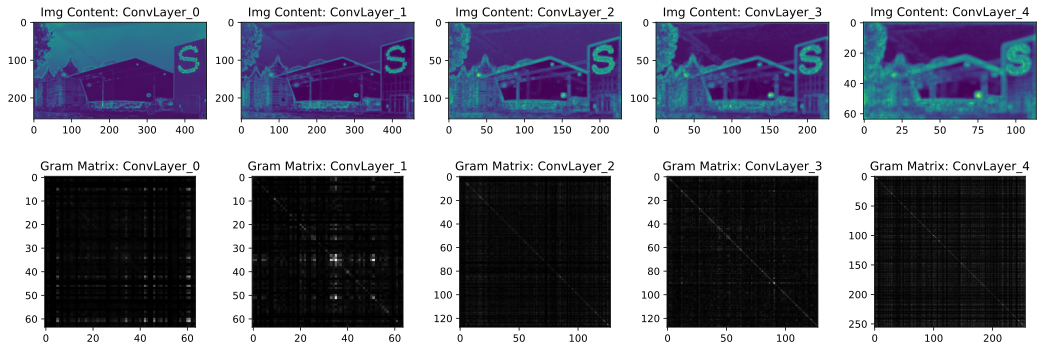

In [140]:
fig, ax = plt.subplots(2, 5, figsize=(18, 6))

for i in range(5):
    pic = np.mean(feature_maps[i].detach().cpu().squeeze().numpy(), axis=0) # mean over all the channels and make it single channel
    pic = (pic - np.min(pic)/(np.max(pic)-np.min(pic)))
    ax[0, i].imshow(pic)
    ax[0, i].set_title(f"Img Content: {feature_names[i]}")

    pic = gram_matrix(feature_maps[i]).cpu().detach().numpy()
    pic = (pic - np.min(pic)/(np.max(pic)-np.min(pic)))
    ax[1, i].imshow(pic, vmax=.1, cmap="gray")
    ax[1, i].set_title(f"Gram Matrix: {feature_names[i]}")

plt.show()

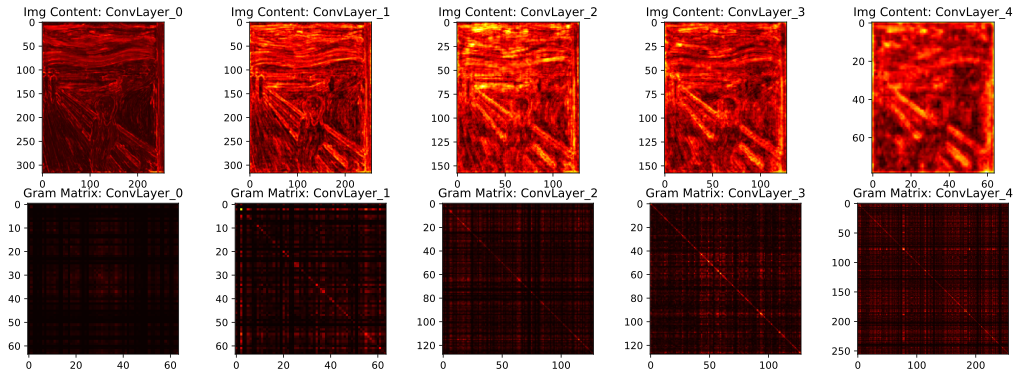

In [141]:
style_maps, style_names = get_feature_map_activations(img_style, vggnet)
fig, ax = plt.subplots(2, 5, figsize=(18, 6))
for i in range(5):
    pic = torch.mean(style_maps[i].cpu().squeeze(), dim=0) # mean over all the channels and make it single channel
    pic = (pic - torch.min(pic)/(torch.max(pic)-torch.min(pic)))
    ax[0, i].imshow(pic.detach(), cmap="hot")
    ax[0, i].set_title(f"Img Content: {style_names[i]}")
    pic = gram_matrix(style_maps[i]).cpu().detach()
    pic = (pic - torch.min(pic)/(torch.max(pic)-torch.min(pic)))
    ax[1, i].imshow(pic, cmap="hot", vmax=.1)
    ax[1, i].set_title(f"Gram Matrix: {style_names[i]}")
plt.show()

In [142]:
layers_content = [feature_names[1], feature_names[4]]
layers_style = [feature_names[1], feature_names[2], feature_names[3], feature_names[4], feature_names[5]]
weights_style = [       1       ,       .5        ,         .5      ,       .2        ,         .1      ]

In [143]:
layers_style

['ConvLayer_1', 'ConvLayer_2', 'ConvLayer_3', 'ConvLayer_4', 'ConvLayer_5']

In [144]:
target = img_target.clone()
target.require_grad = True
target.to(device=device)

tensor([[[[ 0.0211,  0.1790, -0.0031,  ...,  0.0171,  0.1405,  0.3043],
          [ 0.0482,  0.2749,  0.1087,  ..., -0.3543,  0.0680, -0.3015],
          [ 0.4114,  0.3696,  0.3971,  ..., -0.1360, -0.0769, -0.1634],
          ...,
          [-0.1598, -0.2113, -0.1576,  ...,  0.1864,  0.0174, -0.2008],
          [-0.2253, -0.3475,  0.2542,  ..., -0.0209,  0.0145,  0.0267],
          [-0.1751, -0.1080, -0.1699,  ..., -0.2790,  0.2026,  0.2631]],

         [[ 0.3281,  0.2377, -0.1684,  ...,  0.0159,  0.4712,  0.8887],
          [ 0.0885,  0.2578,  0.1124,  ..., -0.0174,  0.1748,  0.6888],
          [ 0.0057, -0.0736,  0.1990,  ...,  0.1954,  0.3748,  0.3129],
          ...,
          [ 0.3934,  0.4688,  0.2329,  ...,  0.6338,  0.2491,  0.2992],
          [ 0.1069,  0.2764,  0.3938,  ...,  0.5116,  0.2935,  0.1347],
          [ 0.0567,  0.3731,  0.0542,  ...,  0.1044,  0.1129,  0.1145]],

         [[ 0.2410,  0.8393,  0.6073,  ...,  0.2744,  0.2287,  0.2042],
          [ 0.0628,  0.4677,  

In [145]:
style_scaling = 1e6
epochs = 1500

optimizer = torch.optim.RMSprop([target], lr=.005)

In [146]:
style_maps, style_names = get_feature_map_activations(img_style, vggnet)

In [147]:
layers_content

['ConvLayer_1', 'ConvLayer_4']

In [148]:
# make a copy of the target image and push to GPU
target = img_target.clone()
target.requires_grad = True
target = target.to(device)
styleScaling = 1e6

# number of epochs to train
numepochs = 1500

# optimizer for backprop
optimizer = torch.optim.RMSprop([target],lr=.005)


for epochi in range(numepochs):

  # extract the target feature maps
  targetFeatureMaps,targetFeatureNames = get_feature_map_activations(target,vggnet)


  # initialize the individual loss components
  styleLoss = 0
  contentLoss = 0

  # loop over layers
  for layeri in range(len(targetFeatureNames)):


    # compute the content loss
    if targetFeatureNames[layeri] in layers_content:
      contentLoss += torch.mean( (targetFeatureMaps[layeri]-feature_maps[layeri])**2 )


    # compute the style loss
    if targetFeatureNames[layeri] in layers_style:
      
      # Gram matrices
      Gtarget = gram_matrix(targetFeatureMaps[layeri])
      Gstyle  = gram_matrix(style_maps[layeri])

      # compute their loss (de-weighted with increasing depth)
      styleLoss += torch.mean( (Gtarget-Gstyle)**2 ) * weights_style[layers_style.index(targetFeatureNames[layeri])]

  
  # combined loss
  combiloss = styleScaling*styleLoss + contentLoss

  # finally ready for backprop!
  optimizer.zero_grad()
  combiloss.backward()
  optimizer.step()


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.